In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load and preprocess your custom dataset
data_path = '/kaggle/input/vae11/Classes'
image_size = (180, 180, 3)

# Load and preprocess your custom dataset
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size[:2])
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

# Create a dataset from the image folder
custom_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    image_size=image_size[:2],
    batch_size=32,
    shuffle=True,
)
custom_dataset = custom_dataset.map(lambda x, _: (x / 255.0, x / 255.0))  # Normalize images



Found 765 files belonging to 2 classes.


2024-01-04 09:00:59.403770: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-04 09:00:59.403876: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-04 09:00:59.403949: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-04 09:00:59.404017: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-04 09:00:59.404095: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-04 09:00:59.404303: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-04 09:00:59.404415: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

In [6]:
# Step 2: Define the VAE model
class VAE(tf.keras.Model):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = models.Sequential([
            layers.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(pool_size=2, strides=2),
            layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(pool_size=2, strides=2),
        ])

        self.flatten = layers.Flatten()

        self.fc1 = layers.Dense(400, activation='relu')
        self.fc21 = layers.Dense(256)
        self.fc22 = layers.Dense(256)
        self.fc3 = layers.Dense(400, activation='relu')
        self.fc4 = layers.Dense(32 * 45 * 45, activation='relu')

        # Decoder
        self.decoder = models.Sequential([
            layers.Reshape((45, 45, 32)),
            layers.Conv2DTranspose(16, kernel_size=2, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(3, kernel_size=2, strides=2, activation='sigmoid', padding='same'),
        ])

    def encode(self, x):
        h1 = self.encoder(x)
        h1 = self.flatten(h1)
        h2 = self.fc1(h1)
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = tf.exp(0.5 * logvar)
        eps = tf.random.normal(shape=tf.shape(std))
        return mu + eps * std

    def decode(self, z):
        h3 = self.fc3(z)
        h3 = self.fc4(h3)
        h3 = tf.reshape(h3, (-1, 45, 45, 32))
        return self.decoder(h3)

    def call(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Step 3: Initialize the VAE model
model = VAE()

# Step 4: Define the loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = tf.keras.losses.binary_crossentropy(x, recon_x)
    BCE = tf.reduce_sum(BCE)
    KLD = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))
    return BCE + KLD

# Step 5: Set up the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Step 6: Implement the training loop
def train(epoch):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(custom_dataset):
        with tf.GradientTape() as tape:
            recon_batch, mu, logvar = model.call(data)
            loss = loss_function(recon_batch, data, mu, logvar)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss += loss.numpy()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(custom_dataset) * 32,
                100. * batch_idx / len(custom_dataset),
                loss / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(custom_dataset)))

    

Train Epoch: 1 [0/768 (0%)]	Loss: 22464.511719
====> Epoch: 1 Average loss: 772778.6432
Train Epoch: 2 [0/768 (0%)]	Loss: 22329.404297
====> Epoch: 2 Average loss: 709054.7109
Train Epoch: 3 [0/768 (0%)]	Loss: 22226.314453
====> Epoch: 3 Average loss: 701026.1458
Train Epoch: 4 [0/768 (0%)]	Loss: 22061.494141
====> Epoch: 4 Average loss: 695378.7604
Train Epoch: 5 [0/768 (0%)]	Loss: 21813.484375
====> Epoch: 5 Average loss: 691326.2865
Train Epoch: 6 [0/768 (0%)]	Loss: 21494.974609
====> Epoch: 6 Average loss: 689624.3464
Train Epoch: 7 [0/768 (0%)]	Loss: 21763.751953
====> Epoch: 7 Average loss: 686973.2630
Train Epoch: 8 [0/768 (0%)]	Loss: 20897.730469
====> Epoch: 8 Average loss: 684959.6953
Train Epoch: 9 [0/768 (0%)]	Loss: 21679.976562
====> Epoch: 9 Average loss: 683237.9948
Train Epoch: 10 [0/768 (0%)]	Loss: 21506.433594
====> Epoch: 10 Average loss: 681017.0078
Train Epoch: 11 [0/768 (0%)]	Loss: 21563.148438
====> Epoch: 11 Average loss: 677801.5234
Train Epoch: 12 [0/768 (0%)]

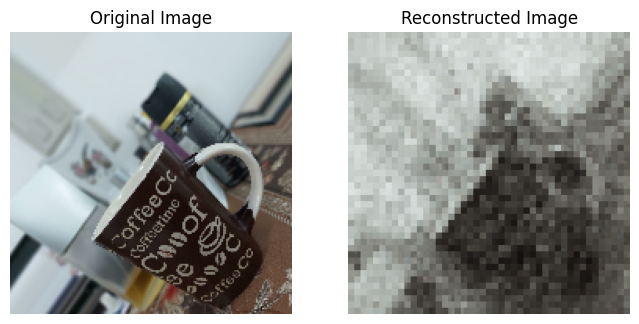

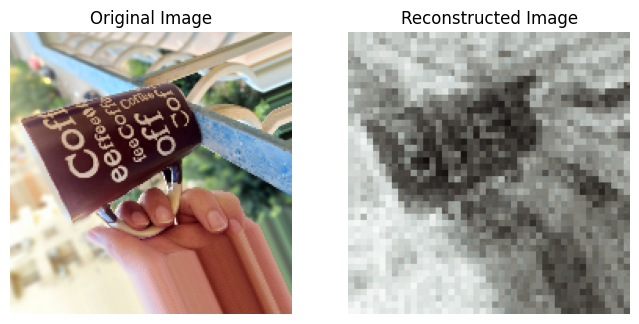

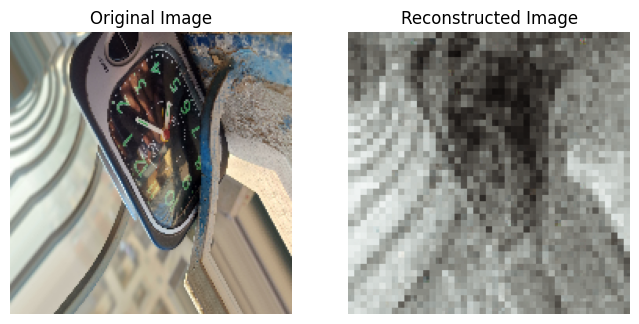

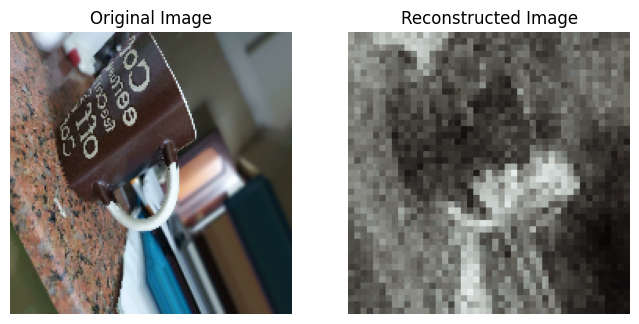

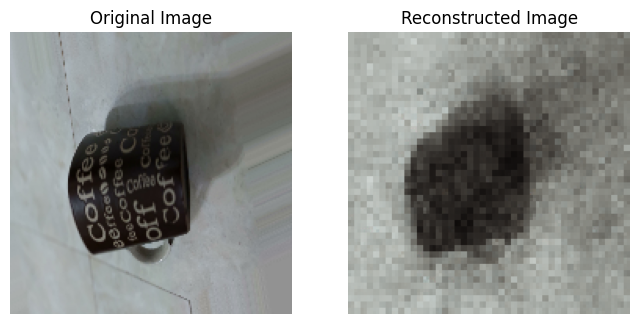

In [8]:
# Step 7: Generate and display reconstructed images
def generate_reconstructed_images():
    for i, (data, _) in enumerate(custom_dataset.take(5)):
        recon_batch, _, _ = model(data)

        # Convert tensors to numpy arrays for visualization
        data_np = np.clip(data.numpy().transpose(0, 1, 2, 3), 0, 1)
        recon_np = np.clip(recon_batch.numpy().transpose(0, 1, 2, 3), 0, 1)

        # Display original and reconstructed images side by side
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(data_np[i])
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Reconstructed Image')
        plt.imshow(recon_np[i])
        plt.axis('off')

        plt.show()

# Train the VAE
for epoch in range(1, 151):
    train(epoch)

# Generate and display reconstructed images
generate_reconstructed_images()

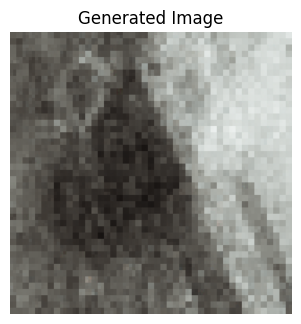

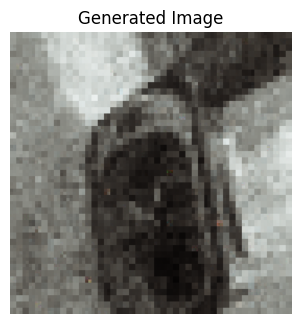

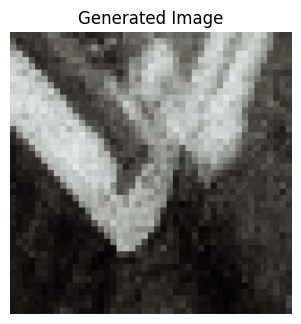

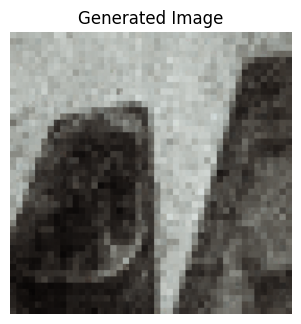

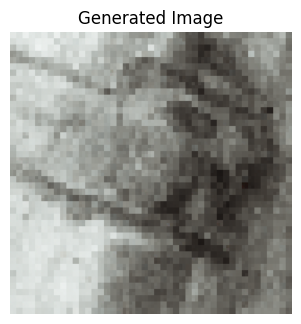

In [21]:
import ipywidgets as widgets
from IPython.display import display

def generate_random_images(num_images=5):
    # Generate random samples from the latent space
    random_samples = tf.random.normal(shape=(num_images, 256))

    # Decode the random samples
    generated_images = model.decode(random_samples)

    # Convert tensors to numpy arrays for visualization
    generated_images_np = np.clip(generated_images.numpy().transpose(0, 1, 2, 3), 0, 1)

    # Display the generated images
    for i in range(num_images):
        plt.figure(figsize=(4, 4))
        plt.title('Generated Image {}'.format(i+1))
        plt.imshow(generated_images_np[i])
        plt.axis('off')
        plt.show()
        
generate_random_images()